In [152]:
import librosa
import os
import pandas as pd
from tqdm import tqdm
from glob import glob
import warnings
warnings.warn("ignore", category=FutureWarning)
warnings.warn("ignore", category=UserWarning)
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Concatenate, Input
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

C:\Users\Nam\AppData\Local\Temp\ipykernel_5840\438234842.py:7: FutureWarning: ignore
  warnings.warn("ignore", category=FutureWarning)
C:\Users\Nam\AppData\Local\Temp\ipykernel_5840\438234842.py:8: UserWarning: ignore
  warnings.warn("ignore", category=UserWarning)


In [153]:
DATA_DIR_EMO = "/Speech Emotion Recognition/EmoDB/wav"
DATA_DIR_RAV = "/Speech Emotion Recognition/RAVDESS"

In [ ]:
def extract_features(file_path, sr=22050, duration=3, offset=0.5):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration, offset=offset)
        y_trim, _ = librosa.effects.trim(y, top_db=20)

        feats = []

        # ===== MFCC (static) =====
        mfcc = librosa.feature.mfcc(y=y_trim, sr=sr, n_mfcc=13)
        feats += [
            np.mean(mfcc, axis=1),
            np.std(mfcc, axis=1)
        ]

        # ===== Delta MFCC (dynamic) =====
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        feats += [
            np.mean(delta, axis=1),
            np.std(delta, axis=1),
            np.mean(delta2, axis=1),
            np.std(delta2, axis=1)
        ]

        # ===== Chroma (giữ nhưng giảm trọng số) =====
        chroma = librosa.feature.chroma_stft(y=y_trim, sr=sr)
        feats += [
            np.mean(chroma, axis=1)
        ]

        # ===== Mel spectrogram (giữ block, giảm nhiễu) =====
        mel = librosa.power_to_db(
            librosa.feature.melspectrogram(y=y_trim, sr=sr, n_fft=2048),
            ref=np.max
        )
        feats += [
            np.mean(mel, axis=1) 
        ]

        # ===== Tonnetz (giữ block, nhưng làm nhẹ) =====
        tonnetz = librosa.feature.tonnetz(
            y=librosa.effects.harmonic(y_trim), sr=sr
        )
        feats += [
            np.mean(tonnetz, axis=1)
        ]

        # ===== Spectral features =====
        for f in [
            librosa.feature.spectral_centroid,
            librosa.feature.spectral_bandwidth,
            librosa.feature.spectral_rolloff
        ]:
            v = f(y=y_trim, sr=sr)
            feats += [
                np.mean(v, axis=1),
                np.std(v, axis=1)
            ]

        # ===== Zero Crossing Rate =====
        zcr = librosa.feature.zero_crossing_rate(y_trim)
        feats += [
            np.mean(zcr, axis=1),
            np.std(zcr, axis=1)
        ]

        # ===== HPSS (giữ block nhưng giảm nhiễu) =====
        y_harmonic, y_percussive = librosa.effects.hpss(y_trim)
        feats += [
            np.mean(librosa.feature.spectral_centroid(y=y_harmonic, sr=sr), axis=1),
            np.mean(librosa.feature.spectral_centroid(y=y_percussive, sr=sr), axis=1)
        ]

        # ===== Tempo (giữ block, làm ổn định) =====
        tempo, _ = librosa.beat.beat_track(y=y_trim, sr=sr)
        feats.append([tempo / 200.0])  # normalize tempo

        return np.hstack([np.hstack(f).flatten() for f in feats])

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [155]:
ravdness = "/Speech Emotion Recognition/RAVDNESS/audio_speech_actors_01-24"

ravdness_emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy",
    "04": "sad", "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

features_list_ravdness = []
features_list_ravdness_not = []

for actor in tqdm(os.listdir(ravdness), desc="Extracting RAVDNESS features"):
    for file in tqdm(os.listdir(os.path.join(ravdness, actor)), desc=f"Processing actor {actor}", leave=False):
        code = file.split("-")[2]
        label = ravdness_emotion_map.get(code)
        if label:
            features = extract_features(os.path.join(ravdness, actor, file))
            if features is not None:
                features_list_ravdness.append([*features, label])
            else:
                features_list_ravdness_not.append(file)

Extracting RAVDNESS features:   0%|          | 0/24 [00:00<?, ?it/s]c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=864
  warnings.warn(
c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=432
  warnings.warn(
c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=880
  warnings.warn(
c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=440
  warnings.warn(
c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=816
  warnings.warn(
c:

In [ ]:
print(f"Could not extract features from {len(features_list_ravdness_not)} files.")
print(f"Extract feature from {len(features_list_ravdness)} files successfully.")

Could not extract features from 0 files.
Extract feature from 1440 files successfully.


In [157]:
emotion_map_en = {
    'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'anxiety',
    'F': 'happiness', 'T': 'sadness', 'N': 'neutral'
}

features_list = []
features_not_list = []

for actor in tqdm(os.listdir(DATA_DIR_EMO), desc="Extracting features"):
    code = actor[5]
    label = emotion_map_en.get(code)
    if label:
        features = extract_features(os.path.join(DATA_DIR_EMO, actor))
        if features is not None:
            features_list.append([*features, label])
        else:
            features_not_list.append(actor)

Extracting features:   0%|          | 1/535 [00:00<01:22,  6.51it/s]c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=304
  warnings.warn(
Extracting features:   1%|          | 4/535 [00:00<01:16,  6.92it/s]c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=280
  warnings.warn(
Extracting features:   2%|▏         | 9/535 [00:01<01:10,  7.43it/s]c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=336
  warnings.warn(
Extracting features:   2%|▏         | 11/535 [00:01<01:13,  7.13it/s]c:\Users\Nam\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=328


In [158]:
print(f"Could not extract features from {len(features_not_list)} files.")
print(f"Extract feature from {len(features_list)} files successfully.")

Could not extract features from 0 files.
Extract feature from 535 files successfully.


In [159]:
features_list.extend(features_list_ravdness)
print(f"Total extracted features: {len(features_list)}")

Total extracted features: 1975


In [160]:
features_dims = len(features_list[0]) - 1  # Exclude label
columns = [f"feat_{i+1}" for i in range(features_dims)] + ["label"]
import pandas as pd
features_df = pd.DataFrame(features_list, columns=columns)

label_map = {
    'anger': 'angry', 'angry': 'angry', 'boredom': 'boredom', 'disgust': 'disgust',
    'anxiety': 'fear', 'fearful': 'fear', 'happy': 'happy', 'happiness': 'happy', 'sadness': 'sad', 
    'sad': 'sad', 'neutral': 'neutral', 'calm': 'calm', 'surprised': 'surprised'
    }

features_df['label'] = features_df['label'].map(label_map)

features_df = features_df.dropna()
print("Emotion raw distribution:")
print(features_df['label'].value_counts())

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler

smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(features_df.drop('label', axis=1), features_df['label'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
n_classes = len(le.classes_)

print("Emotion distribution after SMOTE:")
print(f"Final dataset shape: {X_scaled.shape}")
print(f"Number of classes: {n_classes}")
print(f"Classes: {le.classes_}")
dist_after = pd.Series(y_resampled).value_counts().sort_index()
print(dist_after)

Emotion raw distribution:
label
angry        319
happy        263
fear         261
sad          254
disgust      238
calm         192
surprised    192
neutral      175
boredom       81
Name: count, dtype: int64
Emotion distribution after SMOTE:
Final dataset shape: (2871, 235)
Number of classes: 9
Classes: ['angry' 'boredom' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad'
 'surprised']
label
angry        319
boredom      319
calm         319
disgust      319
fear         319
happy        319
neutral      319
sad          319
surprised    319
Name: count, dtype: int64


In [161]:
features_df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_227,feat_228,feat_229,feat_230,feat_231,feat_232,feat_233,feat_234,feat_235,label
0,-259.306366,118.692642,-42.210293,59.137581,-29.219238,28.274803,-27.236458,3.713927,-13.554752,-5.018629,...,1674.774504,395.072293,3655.362802,1714.241587,0.113383,0.108931,1561.175777,2199.767862,0.861328,happy
1,-235.314697,144.785416,-33.509594,55.797646,-9.234925,15.800950,-14.553348,-3.550443,-14.700686,0.611230,...,1352.924981,364.177553,2805.942007,1617.681695,0.089431,0.092658,1083.178339,1657.780154,1.076660,neutral
2,-193.059723,93.601166,-74.417206,42.221249,-31.032887,14.639728,-18.183630,-3.303562,-21.939207,-6.919589,...,1612.490038,351.011711,4054.917480,1336.825041,0.142344,0.102308,1936.299835,2424.620054,0.807495,angry
3,-256.581329,96.778564,-34.473286,36.376202,-23.218485,20.299788,-17.471504,3.994059,-18.948830,-11.639271,...,1802.027333,338.334096,3778.000488,1427.311521,0.072567,0.041490,1611.971787,2096.909120,0.645996,happy
4,-216.017548,158.812790,-27.647911,47.661858,-2.112977,5.491232,-4.910068,0.847383,-18.635485,-6.879899,...,1364.803688,405.167319,2447.308350,1290.687622,0.055203,0.040522,915.950056,1499.553200,0.759995,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,-379.980438,48.630432,-34.797817,-9.069886,-33.042046,-17.983446,-29.920321,-29.757931,-14.569332,-15.163612,...,2121.678812,443.381247,4517.383613,2116.652709,0.148037,0.129449,2222.225514,2886.854166,0.416772,surprised
1971,-353.933105,77.175125,-24.605932,-16.593962,-28.600735,-27.957191,-19.950663,-21.583857,-18.038559,-8.960145,...,2139.488938,616.838189,4304.323761,2605.052740,0.132874,0.131419,2037.017580,2713.168736,1.076660,surprised
1972,-355.726044,59.356083,-29.582508,-11.219915,-25.907021,-31.253061,-21.519539,-21.520571,-15.405990,-2.240791,...,2271.443164,454.497634,4809.782298,2290.337723,0.150760,0.129250,2502.804753,2960.216822,0.561736,surprised
1973,-295.563354,37.496223,-11.500656,-5.418467,-26.979445,-11.356391,-17.990105,-14.048766,-5.372526,-15.589647,...,2427.122032,395.047674,5607.006836,2220.655053,0.172465,0.166179,2860.351840,3324.423343,0.993840,surprised


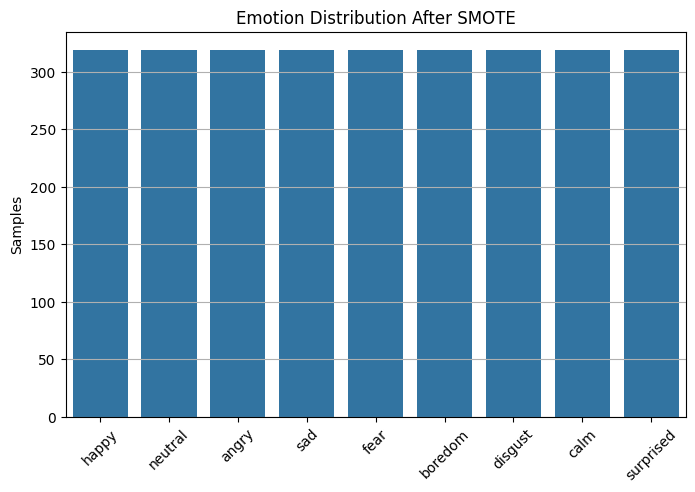

In [162]:
# Emotion distribution after SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

emotion_counts = Counter(y_resampled)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()))
plt.title("Emotion Distribution After SMOTE")
plt.ylabel("Samples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

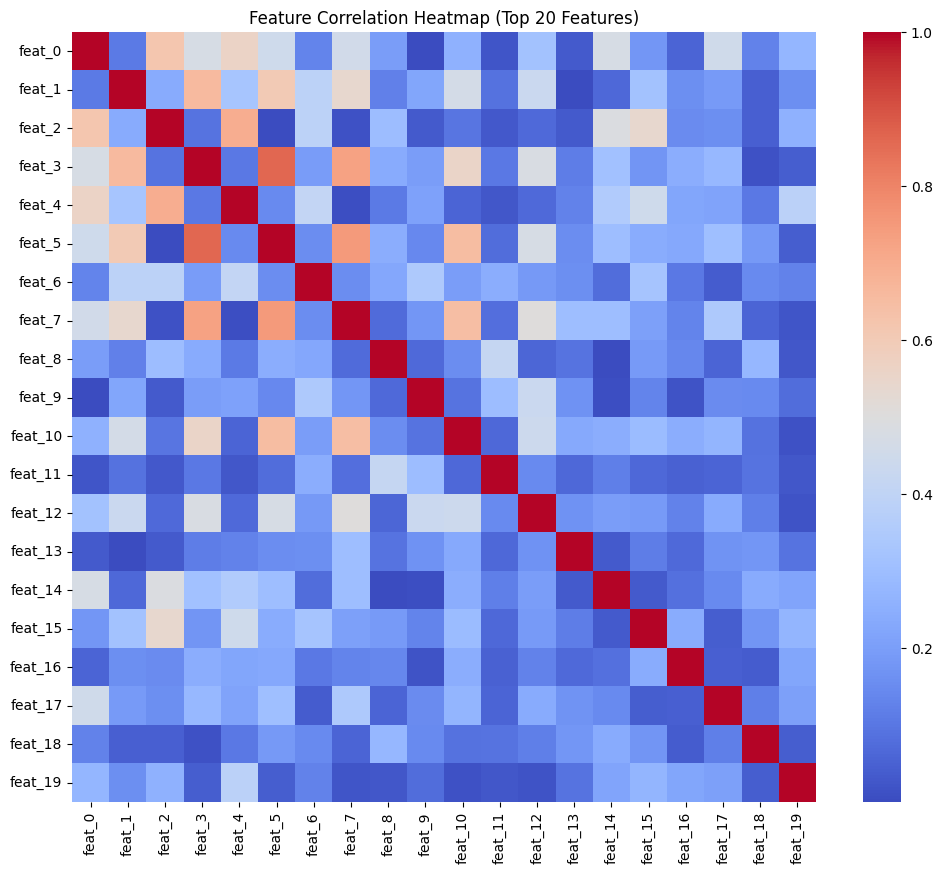

In [163]:
# Feature correlation heatmap (first 20 features)
X_df = pd.DataFrame(X_scaled, columns=[f'feat_{i}' for i in range(X_scaled.shape[1])])
plt.figure(figsize=(12, 10))
sns.heatmap(X_df.corr().abs().iloc[:20, :20], cmap='coolwarm')
plt.title("Feature Correlation Heatmap (Top 20 Features)")
plt.show()

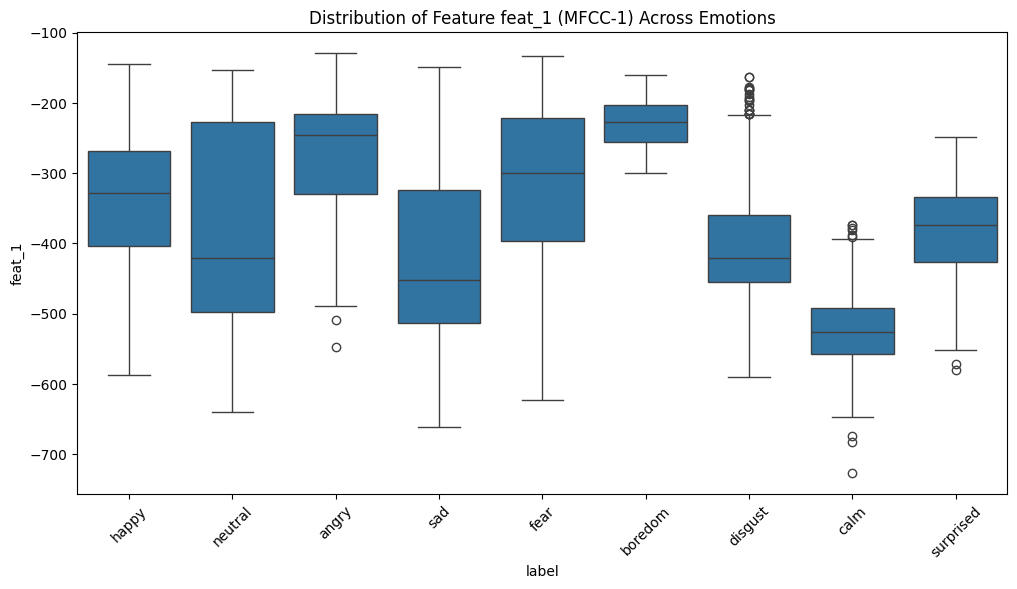

In [173]:
# Boxplot for MFCC feature (feat_0)
df_vis = features_df.copy()
df_vis['label_encoded'] = le.transform(df_vis['label'])
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='feat_1', data=df_vis)
plt.title("Distribution of Feature feat_1 (MFCC-1) Across Emotions")
plt.xticks(rotation=45)
plt.show()

In [165]:
def create_advanced_model(input_dim, n_classes):
    """Create an advanced DNN model with multiple techniques"""
    inputs = Input(shape=(input_dim,))

    # First branch - Deep layers
    x1 = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.4)(x1)
    x1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)

    # Second branch - Wider layers
    x2 = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.4)(x2)
    x2 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)

    # Combine branches
    combined = Concatenate()([x1, x2])

    # Final layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [166]:
def train_with_cv(X, y, n_splits=5):
    """Train model with cross-validation"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nTraining Fold {fold + 1}/{n_splits}")

        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Create model for this fold
        model = create_advanced_model(X.shape[1], n_classes)

        # Compile with advanced optimizer
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7),
            ModelCheckpoint(f'best_model_fold_{fold}.h5', monitor='val_accuracy',
                          save_best_only=True, mode='max')
        ]

        # Train
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=150,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate
        val_pred = model.predict(X_val_fold)
        val_pred_classes = np.argmax(val_pred, axis=1)
        accuracy = accuracy_score(y_val_fold, val_pred_classes)
        cv_scores.append(accuracy)
        models.append(model)

        print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

    return models, cv_scores

# Run cross-validation
print("Starting cross-validation training...")
models, cv_scores = train_with_cv(X_scaled, y_encoded)

print(f"\nCross-validation results:")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
print(f"Individual fold scores: {cv_scores}")

Starting cross-validation training...

Training Fold 1/5
Epoch 1/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2676 - loss: 4.6544

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2726 - loss: 4.6334 - val_accuracy: 0.4991 - val_loss: 3.9638 - learning_rate: 0.0010
Epoch 2/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5162 - loss: 3.7722

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5170 - loss: 3.7707 - val_accuracy: 0.6609 - val_loss: 3.4384 - learning_rate: 0.0010
Epoch 3/150
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6023 - loss: 3.4763

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6033 - loss: 3.4727 - val_accuracy: 0.6870 - val_loss: 3.2513 - learning_rate: 0.0010
Epoch 4/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6559 - loss: 3.2853

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6562 - loss: 3.2841 - val_accuracy: 0.6887 - val_loss: 3.1209 - learning_rate: 0.0010
Epoch 5/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7088 - loss: 3.1076

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7082 - loss: 3.1079 - val_accuracy: 0.7565 - val_loss: 2.9315 - learning_rate: 0.0010
Epoch 6/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7219 - loss: 2.9688

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7220 - loss: 2.9681 - val_accuracy: 0.7878 - val_loss: 2.7652 - learning_rate: 0.0010
Epoch 7/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7819 - loss: 2.8030

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7811 - loss: 2.8038 - val_accuracy: 0.7983 - val_loss: 2.7075 - learning_rate: 0.0010
Epoch 8/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7880 - loss: 2.6745

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7880 - loss: 2.6744 - val_accuracy: 0.8017 - val_loss: 2.6443 - learning_rate: 0.0010
Epoch 9/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8166 - loss: 2.5416 - val_accuracy: 0.7913 - val_loss: 2.5335 - learning_rate: 0.0010
Epoch 10/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8273 - loss: 2.4833

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8269 - loss: 2.4832 - val_accuracy: 0.8191 - val_loss: 2.4369 - learning_rate: 0.0010
Epoch 11/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8162 - loss: 2.4043 - val_accuracy: 0.8174 - val_loss: 2.3929 - learning_rate: 0.0010
Epoch 12/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8278 - loss: 2.3188 - val_accuracy: 0.8104 - val_loss: 2.3229 - learning_rate: 0.0010
Epoch 13/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8578 - loss: 2.1886 - val_accuracy: 0.8191 - val_loss: 2.2594 - learning_rate: 0.0010
Epoch 14/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8489 - loss: 2.1565

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8489 - loss: 2.1562 - val_accuracy: 0.8643 - val_loss: 2.1101 - learning_rate: 0.0010
Epoch 15/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8587 - loss: 2.0746 - val_accuracy: 0.8383 - val_loss: 2.1128 - learning_rate: 0.0010
Epoch 16/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8839 - loss: 1.9466 - val_accuracy: 0.8261 - val_loss: 2.0821 - learning_rate: 0.0010
Epoch 17/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8713 - loss: 1.9314 - val_accuracy: 0.8087 - val_loss: 2.0354 - learning_rate: 0.0010
Epoch 18/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8745 - loss: 1.8457 - val_accuracy: 0.8226 - val_loss: 2.0052 - learning_rate: 0.0010
Epoch 19/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8878 - loss: 1.7616 - val_accuracy: 0.8435 - val_loss: 1.8879 - learning_rate: 0.0010
Epoch 20/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8823 - loss: 1.7163 - val_accuracy:

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2553 - loss: 4.6710 - val_accuracy: 0.5348 - val_loss: 3.7722 - learning_rate: 0.0010
Epoch 2/150
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4667 - loss: 3.8513

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4705 - loss: 3.8424 - val_accuracy: 0.6307 - val_loss: 3.4255 - learning_rate: 0.0010
Epoch 3/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5750 - loss: 3.5122

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5773 - loss: 3.5051 - val_accuracy: 0.6760 - val_loss: 3.2416 - learning_rate: 0.0010
Epoch 4/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6666 - loss: 3.2779

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6665 - loss: 3.2777 - val_accuracy: 0.7300 - val_loss: 3.0535 - learning_rate: 0.0010
Epoch 5/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7160 - loss: 3.0826

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7135 - loss: 3.0852 - val_accuracy: 0.7561 - val_loss: 2.9043 - learning_rate: 0.0010
Epoch 6/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7371 - loss: 2.9526

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7367 - loss: 2.9515 - val_accuracy: 0.7613 - val_loss: 2.7983 - learning_rate: 0.0010
Epoch 7/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7540 - loss: 2.8488

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7542 - loss: 2.8482 - val_accuracy: 0.7822 - val_loss: 2.7489 - learning_rate: 0.0010
Epoch 8/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7979 - loss: 2.6511

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7977 - loss: 2.6513 - val_accuracy: 0.7962 - val_loss: 2.6065 - learning_rate: 0.0010
Epoch 9/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7983 - loss: 2.5778 - val_accuracy: 0.7805 - val_loss: 2.5487 - learning_rate: 0.0010
Epoch 10/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8092 - loss: 2.4664

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8091 - loss: 2.4667 - val_accuracy: 0.8258 - val_loss: 2.4307 - learning_rate: 0.0010
Epoch 11/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8227 - loss: 2.3941 - val_accuracy: 0.8188 - val_loss: 2.3810 - learning_rate: 0.0010
Epoch 12/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8337 - loss: 2.2915

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8337 - loss: 2.2912 - val_accuracy: 0.8432 - val_loss: 2.2884 - learning_rate: 0.0010
Epoch 13/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8626 - loss: 2.1514 - val_accuracy: 0.7840 - val_loss: 2.3562 - learning_rate: 0.0010
Epoch 14/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8470 - loss: 2.1128 - val_accuracy: 0.8031 - val_loss: 2.2128 - learning_rate: 0.0010
Epoch 15/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8434 - loss: 2.0948 - val_accuracy: 0.8136 - val_loss: 2.1441 - learning_rate: 0.0010
Epoch 16/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8751 - loss: 1.9785

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8750 - loss: 1.9787 - val_accuracy: 0.8554 - val_loss: 2.0314 - learning_rate: 0.0010
Epoch 17/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8803 - loss: 1.8903 - val_accuracy: 0.8118 - val_loss: 2.0248 - learning_rate: 0.0010
Epoch 18/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8849 - loss: 1.8196 - val_accuracy: 0.8345 - val_loss: 1.9568 - learning_rate: 0.0010
Epoch 19/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8949 - loss: 1.7445 - val_accuracy: 0.8362 - val_loss: 1.9321 - learning_rate: 0.0010
Epoch 20/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8999 - loss: 1.6577 - val_accuracy: 0.8240 - val_loss: 1.8784 - learning_rate: 0.0010
Epoch 21/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8694 - loss: 1.7092 - val_accuracy: 0.8362 - val_loss: 1.8189 - learning_rate: 0.0010
Epoch 22/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8782 - loss: 1.6321 - val_accuracy:

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8790 - loss: 1.3995 - val_accuracy: 0.8571 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 30/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9013 - loss: 1.3269 - val_accuracy: 0.8432 - val_loss: 1.5546 - learning_rate: 0.0010
Epoch 31/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9110 - loss: 1.2777 - val_accuracy: 0.8380 - val_loss: 1.5881 - learning_rate: 0.0010
Epoch 32/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9115 - loss: 1.2560 - val_accuracy: 0.8345 - val_loss: 1.5123 - learning_rate: 0.0010
Epoch 33/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9045 - loss: 1.2257 - val_accuracy: 0.8537 - val_loss: 1.3877 - learning_rate: 0.0010
Epoch 34/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9244 - loss: 1.1447 - val_accuracy: 0.8502 - val_loss: 1.4052 - learning_rate: 0.0010
Epoch 35/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9112 - loss: 1.1546

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9106 - loss: 1.1571 - val_accuracy: 0.8641 - val_loss: 1.4187 - learning_rate: 0.0010
Epoch 36/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8966 - loss: 1.1867 - val_accuracy: 0.8537 - val_loss: 1.3847 - learning_rate: 0.0010
Epoch 37/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9158 - loss: 1.1073 - val_accuracy: 0.8240 - val_loss: 1.4298 - learning_rate: 0.0010
Epoch 38/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9134 - loss: 1.0989 - val_accuracy: 0.8449 - val_loss: 1.3856 - learning_rate: 0.0010
Epoch 39/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9035 - loss: 1.1077 - val_accuracy: 0.8449 - val_loss: 1.3515 - learning_rate: 0.0010
Epoch 40/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9190 - loss: 1.0478 - val_accuracy: 0.8380 - val_loss: 1.3775 - learning_rate: 0.0010
Epoch 41/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9287 - loss: 1.0011 - val_accuracy:

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2668 - loss: 4.6355 - val_accuracy: 0.5122 - val_loss: 3.8005 - learning_rate: 0.0010
Epoch 2/150
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4804 - loss: 3.8444

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4824 - loss: 3.8366 - val_accuracy: 0.6167 - val_loss: 3.4363 - learning_rate: 0.0010
Epoch 3/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5749 - loss: 3.5353

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5758 - loss: 3.5320 - val_accuracy: 0.6899 - val_loss: 3.1983 - learning_rate: 0.0010
Epoch 4/150
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6558 - loss: 3.2765

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6561 - loss: 3.2747 - val_accuracy: 0.7108 - val_loss: 3.0627 - learning_rate: 0.0010
Epoch 5/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6907 - loss: 3.1432

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6924 - loss: 3.1372 - val_accuracy: 0.7875 - val_loss: 2.8528 - learning_rate: 0.0010
Epoch 6/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7482 - loss: 2.9258 - val_accuracy: 0.7840 - val_loss: 2.7799 - learning_rate: 0.0010
Epoch 7/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7610 - loss: 2.7813 - val_accuracy: 0.7787 - val_loss: 2.7207 - learning_rate: 0.0010
Epoch 8/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7866 - loss: 2.6970

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7866 - loss: 2.6965 - val_accuracy: 0.8153 - val_loss: 2.5692 - learning_rate: 0.0010
Epoch 9/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8088 - loss: 2.5620 - val_accuracy: 0.8153 - val_loss: 2.4983 - learning_rate: 0.0010
Epoch 10/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8367 - loss: 2.4454

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8353 - loss: 2.4472 - val_accuracy: 0.8258 - val_loss: 2.4650 - learning_rate: 0.0010
Epoch 11/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8381 - loss: 2.3781 - val_accuracy: 0.8240 - val_loss: 2.3474 - learning_rate: 0.0010
Epoch 12/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8342 - loss: 2.2779

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8338 - loss: 2.2786 - val_accuracy: 0.8293 - val_loss: 2.2708 - learning_rate: 0.0010
Epoch 13/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8344 - loss: 2.2445 - val_accuracy: 0.8275 - val_loss: 2.2263 - learning_rate: 0.0010
Epoch 14/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8498 - loss: 2.1314 - val_accuracy: 0.8223 - val_loss: 2.1886 - learning_rate: 0.0010
Epoch 15/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8635 - loss: 2.0396 - val_accuracy: 0.8014 - val_loss: 2.1360 - learning_rate: 0.0010
Epoch 16/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8816 - loss: 1.9527

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8801 - loss: 1.9548 - val_accuracy: 0.8362 - val_loss: 2.0817 - learning_rate: 0.0010
Epoch 17/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8712 - loss: 1.9261 - val_accuracy: 0.8240 - val_loss: 2.0219 - learning_rate: 0.0010
Epoch 18/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8820 - loss: 1.8569

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8815 - loss: 1.8575 - val_accuracy: 0.8432 - val_loss: 1.9423 - learning_rate: 0.0010
Epoch 19/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8607 - loss: 1.8200

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8605 - loss: 1.8203 - val_accuracy: 0.8449 - val_loss: 1.8955 - learning_rate: 0.0010
Epoch 20/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8918 - loss: 1.7144 - val_accuracy: 0.8275 - val_loss: 1.8818 - learning_rate: 0.0010
Epoch 21/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9061 - loss: 1.6397 - val_accuracy: 0.8415 - val_loss: 1.8038 - learning_rate: 0.0010
Epoch 22/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8849 - loss: 1.6370 - val_accuracy: 0.8345 - val_loss: 1.7725 - learning_rate: 0.0010
Epoch 23/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8898 - loss: 1.5864 - val_accuracy: 0.8449 - val_loss: 1.6987 - learning_rate: 0.0010
Epoch 24/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8874 - loss: 1.5475

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8874 - loss: 1.5474 - val_accuracy: 0.8571 - val_loss: 1.6194 - learning_rate: 0.0010
Epoch 25/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8929 - loss: 1.4887 - val_accuracy: 0.8310 - val_loss: 1.6619 - learning_rate: 0.0010
Epoch 26/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9033 - loss: 1.4341 - val_accuracy: 0.8467 - val_loss: 1.5925 - learning_rate: 0.0010
Epoch 27/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9227 - loss: 1.3506 - val_accuracy: 0.8537 - val_loss: 1.5874 - learning_rate: 0.0010
Epoch 28/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9078 - loss: 1.3668

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9077 - loss: 1.3663 - val_accuracy: 0.8624 - val_loss: 1.5197 - learning_rate: 0.0010
Epoch 29/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9056 - loss: 1.3277 - val_accuracy: 0.8345 - val_loss: 1.5853 - learning_rate: 0.0010
Epoch 30/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8804 - loss: 1.3507 - val_accuracy: 0.8606 - val_loss: 1.4381 - learning_rate: 0.0010
Epoch 31/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9105 - loss: 1.2897 - val_accuracy: 0.8345 - val_loss: 1.4480 - learning_rate: 0.0010
Epoch 32/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9118 - loss: 1.2296 - val_accuracy: 0.8571 - val_loss: 1.3650 - learning_rate: 0.0010
Epoch 33/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8927 - loss: 1.2293 - val_accuracy: 0.8484 - val_loss: 1.4315 - learning_rate: 0.0010
Epoch 34/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9198 - loss: 1.1843 - val_accuracy:

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.2503 - loss: 4.6791 - val_accuracy: 0.5418 - val_loss: 3.7458 - learning_rate: 0.0010
Epoch 2/150
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4983 - loss: 3.8053

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4995 - loss: 3.8019 - val_accuracy: 0.6132 - val_loss: 3.4322 - learning_rate: 0.0010
Epoch 3/150
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5830 - loss: 3.5102

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5837 - loss: 3.5079 - val_accuracy: 0.6794 - val_loss: 3.2311 - learning_rate: 0.0010
Epoch 4/150
66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6613 - loss: 3.2687

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6604 - loss: 3.2691 - val_accuracy: 0.7300 - val_loss: 2.9940 - learning_rate: 0.0010
Epoch 5/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7126 - loss: 3.0467

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7125 - loss: 3.0468 - val_accuracy: 0.7700 - val_loss: 2.8708 - learning_rate: 0.0010
Epoch 6/150
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7181 - loss: 2.9816

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7182 - loss: 2.9790 - val_accuracy: 0.7892 - val_loss: 2.7668 - learning_rate: 0.0010
Epoch 7/150
66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7831 - loss: 2.7768

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7823 - loss: 2.7760 - val_accuracy: 0.8014 - val_loss: 2.6872 - learning_rate: 0.0010
Epoch 8/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7830 - loss: 2.6625

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7832 - loss: 2.6619 - val_accuracy: 0.8310 - val_loss: 2.5473 - learning_rate: 0.0010
Epoch 9/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7969 - loss: 2.5544 - val_accuracy: 0.7997 - val_loss: 2.5683 - learning_rate: 0.0010
Epoch 10/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8286 - loss: 2.4373 - val_accuracy: 0.8240 - val_loss: 2.4453 - learning_rate: 0.0010
Epoch 11/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8323 - loss: 2.3667 - val_accuracy: 0.8206 - val_loss: 2.3797 - learning_rate: 0.0010
Epoch 12/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8451 - loss: 2.2939 - val_accuracy: 0.8153 - val_loss: 2.3555 - learning_rate: 0.0010
Epoch 13/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8475 - loss: 2.1853 - val_accuracy: 0.8153 - val_loss: 2.2705 - learning_rate: 0.0010
Epoch 14/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8668 - loss: 2.0896

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8665 - loss: 2.0898 - val_accuracy: 0.8345 - val_loss: 2.1878 - learning_rate: 0.0010
Epoch 15/150
66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8468 - loss: 2.0898

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8473 - loss: 2.0861 - val_accuracy: 0.8380 - val_loss: 2.1441 - learning_rate: 0.0010
Epoch 16/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8619 - loss: 1.9811 - val_accuracy: 0.8345 - val_loss: 2.0813 - learning_rate: 0.0010
Epoch 17/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8590 - loss: 1.9234 - val_accuracy: 0.8380 - val_loss: 2.0856 - learning_rate: 0.0010
Epoch 18/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8842 - loss: 1.8099 - val_accuracy: 0.8328 - val_loss: 1.9730 - learning_rate: 0.0010
Epoch 19/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8741 - loss: 1.8047 - val_accuracy: 0.8380 - val_loss: 1.9823 - learning_rate: 0.0010
Epoch 20/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9012 - loss: 1.6895 - val_accuracy: 0.8275 - val_loss: 1.9334 - learning_rate: 0.0010
Epoch 21/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8978 - loss: 1.6581

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8971 - loss: 1.6593 - val_accuracy: 0.8397 - val_loss: 1.8668 - learning_rate: 0.0010
Epoch 22/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8844 - loss: 1.6472 - val_accuracy: 0.8310 - val_loss: 1.8703 - learning_rate: 0.0010
Epoch 23/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8983 - loss: 1.5787 - val_accuracy: 0.7979 - val_loss: 1.9276 - learning_rate: 0.0010
Epoch 24/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8945 - loss: 1.5261

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8947 - loss: 1.5260 - val_accuracy: 0.8415 - val_loss: 1.7340 - learning_rate: 0.0010
Epoch 25/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8902 - loss: 1.5078 - val_accuracy: 0.8380 - val_loss: 1.7081 - learning_rate: 0.0010
Epoch 26/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9009 - loss: 1.4468

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9010 - loss: 1.4467 - val_accuracy: 0.8624 - val_loss: 1.6216 - learning_rate: 0.0010
Epoch 27/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9096 - loss: 1.3794 - val_accuracy: 0.8467 - val_loss: 1.6200 - learning_rate: 0.0010
Epoch 28/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9064 - loss: 1.3716 - val_accuracy: 0.8502 - val_loss: 1.5852 - learning_rate: 0.0010
Epoch 29/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9026 - loss: 1.3635 - val_accuracy: 0.8328 - val_loss: 1.6007 - learning_rate: 0.0010
Epoch 30/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9048 - loss: 1.3247 - val_accuracy: 0.8275 - val_loss: 1.5972 - learning_rate: 0.0010
Epoch 31/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9177 - loss: 1.2683 - val_accuracy: 0.8571 - val_loss: 1.5182 - learning_rate: 0.0010
Epoch 32/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9206 - loss: 1.2165 - val_accura

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9267 - loss: 1.1328 - val_accuracy: 0.8693 - val_loss: 1.3956 - learning_rate: 0.0010
Epoch 35/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9216 - loss: 1.1317 - val_accuracy: 0.8502 - val_loss: 1.4463 - learning_rate: 0.0010
Epoch 36/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8999 - loss: 1.1670 - val_accuracy: 0.8432 - val_loss: 1.4705 - learning_rate: 0.0010
Epoch 37/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9059 - loss: 1.1541 - val_accuracy: 0.8467 - val_loss: 1.4337 - learning_rate: 0.0010
Epoch 38/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9227 - loss: 1.0750 - val_accuracy: 0.8484 - val_loss: 1.3862 - learning_rate: 0.0010
Epoch 39/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9088 - loss: 1.0976 - val_accuracy: 0.8659 - val_loss: 1.3451 - learning_rate: 0.0010
Epoch 40/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9227 - loss: 1.0561 - val_accuracy

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2567 - loss: 4.7146 - val_accuracy: 0.5348 - val_loss: 3.7893 - learning_rate: 0.0010
Epoch 2/150
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4900 - loss: 3.8340

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4930 - loss: 3.8255 - val_accuracy: 0.6516 - val_loss: 3.4145 - learning_rate: 0.0010
Epoch 3/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5923 - loss: 3.5838

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5921 - loss: 3.5801 - val_accuracy: 0.6794 - val_loss: 3.2081 - learning_rate: 0.0010
Epoch 4/150
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6586 - loss: 3.3015

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6586 - loss: 3.2998 - val_accuracy: 0.7422 - val_loss: 3.0084 - learning_rate: 0.0010
Epoch 5/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6964 - loss: 3.1316 - val_accuracy: 0.7352 - val_loss: 2.9376 - learning_rate: 0.0010
Epoch 6/150
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7440 - loss: 2.9625

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7427 - loss: 2.9640 - val_accuracy: 0.7631 - val_loss: 2.8127 - learning_rate: 0.0010
Epoch 7/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7619 - loss: 2.8443

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7619 - loss: 2.8442 - val_accuracy: 0.7718 - val_loss: 2.7292 - learning_rate: 0.0010
Epoch 8/150
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7648 - loss: 2.7484

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7659 - loss: 2.7447 - val_accuracy: 0.8066 - val_loss: 2.5904 - learning_rate: 0.0010
Epoch 9/150
66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8173 - loss: 2.5627

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8150 - loss: 2.5670 - val_accuracy: 0.8153 - val_loss: 2.5299 - learning_rate: 0.0010
Epoch 10/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8121 - loss: 2.5085 - val_accuracy: 0.7944 - val_loss: 2.4833 - learning_rate: 0.0010
Epoch 11/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8085 - loss: 2.4801

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8084 - loss: 2.4796 - val_accuracy: 0.8188 - val_loss: 2.3844 - learning_rate: 0.0010
Epoch 12/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8301 - loss: 2.3301 - val_accuracy: 0.7979 - val_loss: 2.3548 - learning_rate: 0.0010
Epoch 13/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8509 - loss: 2.2190

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8505 - loss: 2.2197 - val_accuracy: 0.8240 - val_loss: 2.2781 - learning_rate: 0.0010
Epoch 14/150
66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8497 - loss: 2.1636

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8491 - loss: 2.1635 - val_accuracy: 0.8310 - val_loss: 2.1998 - learning_rate: 0.0010
Epoch 15/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8542 - loss: 2.1069 - val_accuracy: 0.8206 - val_loss: 2.1459 - learning_rate: 0.0010
Epoch 16/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8831 - loss: 1.9749

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8825 - loss: 1.9753 - val_accuracy: 0.8397 - val_loss: 2.0462 - learning_rate: 0.0010
Epoch 17/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8657 - loss: 1.9249 - val_accuracy: 0.8328 - val_loss: 2.0136 - learning_rate: 0.0010
Epoch 18/150
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8818 - loss: 1.8525

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8810 - loss: 1.8541 - val_accuracy: 0.8415 - val_loss: 1.9652 - learning_rate: 0.0010
Epoch 19/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8909 - loss: 1.8277 - val_accuracy: 0.8415 - val_loss: 1.9127 - learning_rate: 0.0010
Epoch 20/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8887 - loss: 1.7275 - val_accuracy: 0.8397 - val_loss: 1.8406 - learning_rate: 0.0010
Epoch 21/150
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9106 - loss: 1.6435

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9101 - loss: 1.6449 - val_accuracy: 0.8467 - val_loss: 1.7812 - learning_rate: 0.0010
Epoch 22/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8952 - loss: 1.6272 - val_accuracy: 0.8380 - val_loss: 1.8212 - learning_rate: 0.0010
Epoch 23/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8739 - loss: 1.6343 - val_accuracy: 0.8223 - val_loss: 1.7752 - learning_rate: 0.0010
Epoch 24/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8798 - loss: 1.5876 - val_accuracy: 0.8328 - val_loss: 1.7277 - learning_rate: 0.0010
Epoch 25/150
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8968 - loss: 1.4963

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8964 - loss: 1.4968 - val_accuracy: 0.8554 - val_loss: 1.6131 - learning_rate: 0.0010
Epoch 26/150
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9071 - loss: 1.4612

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9063 - loss: 1.4627 - val_accuracy: 0.8659 - val_loss: 1.5628 - learning_rate: 0.0010
Epoch 27/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9099 - loss: 1.4113 - val_accuracy: 0.8484 - val_loss: 1.5877 - learning_rate: 0.0010
Epoch 28/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8958 - loss: 1.4114 - val_accuracy: 0.8188 - val_loss: 1.6124 - learning_rate: 0.0010
Epoch 29/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8945 - loss: 1.3836 - val_accuracy: 0.8502 - val_loss: 1.5319 - learning_rate: 0.0010
Epoch 30/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9106 - loss: 1.3214 - val_accuracy: 0.8502 - val_loss: 1.5284 - learning_rate: 0.0010
Epoch 31/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9116 - loss: 1.2872 - val_accuracy: 0.8240 - val_loss: 1.5237 - learning_rate: 0.0010
Epoch 32/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9269 - loss: 1.2271 - val_accuracy:

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9158 - loss: 1.0917 - val_accuracy: 0.8780 - val_loss: 1.1882 - learning_rate: 0.0010
Epoch 41/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9152 - loss: 1.0561 - val_accuracy: 0.8449 - val_loss: 1.2659 - learning_rate: 0.0010
Epoch 42/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9249 - loss: 1.0198 - val_accuracy: 0.8537 - val_loss: 1.2734 - learning_rate: 0.0010
Epoch 43/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9195 - loss: 1.0119 - val_accuracy: 0.8345 - val_loss: 1.3243 - learning_rate: 0.0010
Epoch 44/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9070 - loss: 1.0345 - val_accuracy: 0.8432 - val_loss: 1.2282 - learning_rate: 0.0010
Epoch 45/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9165 - loss: 0.9709 - val_accuracy: 0.8554 - val_loss: 1.2247 - learning_rate: 0.0010
Epoch 46/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9161 - loss: 0.9996 - val_accuracy:

In [167]:
import joblib
# Split data for final training
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42
)

# Train final model
print("\nTraining final model on full dataset...")
final_model = create_advanced_model(X_scaled.shape[1], n_classes)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
final_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-7),
    ModelCheckpoint('final_best_model.h5', monitor='val_accuracy',
                   save_best_only=True, mode='max')
]

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Save model and preprocessing objects
final_model.save('speech_emotion_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')


Training final model on full dataset...
Epoch 1/200
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2862 - loss: 4.5777

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2882 - loss: 4.5700 - val_accuracy: 0.5174 - val_loss: 3.6939 - learning_rate: 0.0010
Epoch 2/200
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4996 - loss: 3.7586

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5007 - loss: 3.7558 - val_accuracy: 0.6636 - val_loss: 3.3736 - learning_rate: 0.0010
Epoch 3/200
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5945 - loss: 3.4951

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5946 - loss: 3.4937 - val_accuracy: 0.6868 - val_loss: 3.1942 - learning_rate: 0.0010
Epoch 4/200
75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6295 - loss: 3.3192

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6300 - loss: 3.3172 - val_accuracy: 0.7355 - val_loss: 3.0013 - learning_rate: 0.0010
Epoch 5/200
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6833 - loss: 3.1504

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6840 - loss: 3.1475 - val_accuracy: 0.7564 - val_loss: 2.8963 - learning_rate: 0.0010
Epoch 6/200
75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7218 - loss: 2.9792

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7221 - loss: 2.9778 - val_accuracy: 0.7587 - val_loss: 2.8408 - learning_rate: 0.0010
Epoch 7/200
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7539 - loss: 2.7828

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7537 - loss: 2.7832 - val_accuracy: 0.8051 - val_loss: 2.6493 - learning_rate: 0.0010
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7767 - loss: 2.7010 - val_accuracy: 0.8051 - val_loss: 2.5271 - learning_rate: 0.0010
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8200 - loss: 2.5249 - val_accuracy: 0.8028 - val_loss: 2.5013 - learning_rate: 0.0010
Epoch 10/200
75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7999 - loss: 2.5095

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7996 - loss: 2.5097 - val_accuracy: 0.8213 - val_loss: 2.3997 - learning_rate: 0.0010
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8392 - loss: 2.3641 - val_accuracy: 0.8005 - val_loss: 2.3665 - learning_rate: 0.0010
Epoch 12/200
70/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8311 - loss: 2.3149

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8311 - loss: 2.3117 - val_accuracy: 0.8237 - val_loss: 2.2483 - learning_rate: 0.0010
Epoch 13/200
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8288 - loss: 2.2287

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8281 - loss: 2.2293 - val_accuracy: 0.8422 - val_loss: 2.1624 - learning_rate: 0.0010
Epoch 14/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8534 - loss: 2.1063

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8533 - loss: 2.1066 - val_accuracy: 0.8515 - val_loss: 2.1015 - learning_rate: 0.0010
Epoch 15/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8638 - loss: 2.0590 - val_accuracy: 0.8422 - val_loss: 2.0444 - learning_rate: 0.0010
Epoch 16/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8730 - loss: 1.9431 - val_accuracy: 0.8376 - val_loss: 2.0615 - learning_rate: 0.0010
Epoch 17/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8650 - loss: 1.9206 - val_accuracy: 0.8353 - val_loss: 1.9352 - learning_rate: 0.0010
Epoch 18/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8717 - loss: 1.8487 - val_accuracy: 0.8399 - val_loss: 1.8980 - learning_rate: 0.0010
Epoch 19/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8895 - loss: 1.7676 - val_accuracy: 0.8306 - val_loss: 1.8971 - learning_rate: 0.0010
Epoch 20/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8701 - loss: 1.7686 - val_accuracy:

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8595 - loss: 1.6767 - val_accuracy: 0.8538 - val_loss: 1.7118 - learning_rate: 0.0010
Epoch 23/200
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8906 - loss: 1.5691

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8903 - loss: 1.5691 - val_accuracy: 0.8585 - val_loss: 1.7175 - learning_rate: 0.0010
Epoch 24/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8997 - loss: 1.5246 - val_accuracy: 0.8121 - val_loss: 1.7732 - learning_rate: 0.0010
Epoch 25/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8820 - loss: 1.5131 - val_accuracy: 0.8190 - val_loss: 1.7283 - learning_rate: 0.0010
Epoch 26/200
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8786 - loss: 1.4993

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8785 - loss: 1.4985 - val_accuracy: 0.8608 - val_loss: 1.5571 - learning_rate: 0.0010
Epoch 27/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8865 - loss: 1.4329 - val_accuracy: 0.8445 - val_loss: 1.6715 - learning_rate: 0.0010
Epoch 28/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8749 - loss: 1.4601 - val_accuracy: 0.8399 - val_loss: 1.5995 - learning_rate: 0.0010
Epoch 29/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8934 - loss: 1.3731 - val_accuracy: 0.8445 - val_loss: 1.5150 - learning_rate: 0.0010
Epoch 30/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8952 - loss: 1.3391 - val_accuracy: 0.8538 - val_loss: 1.4592 - learning_rate: 0.0010
Epoch 31/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9149 - loss: 1.2716 - val_accuracy: 0.8353 - val_loss: 1.5255 - learning_rate: 0.0010
Epoch 32/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8902 - loss: 1.2727 - val_accuracy:

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9052 - loss: 1.1430 - val_accuracy: 0.8654 - val_loss: 1.3342 - learning_rate: 0.0010
Epoch 39/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8939 - loss: 1.1498 - val_accuracy: 0.8492 - val_loss: 1.3240 - learning_rate: 0.0010
Epoch 40/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9104 - loss: 1.1018 - val_accuracy: 0.8561 - val_loss: 1.2523 - learning_rate: 0.0010
Epoch 41/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9093 - loss: 1.0901 - val_accuracy: 0.8492 - val_loss: 1.3217 - learning_rate: 0.0010
Epoch 42/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9106 - loss: 1.0742 - val_accuracy: 0.8445 - val_loss: 1.2813 - learning_rate: 0.0010
Epoch 43/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9064 - loss: 1.0406 - val_accuracy: 0.8608 - val_loss: 1.2421 - learning_rate: 0.0010
Epoch 44/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8993 - loss: 1.0707 - val_accuracy

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9150 - loss: 0.9635 - val_accuracy: 0.8770 - val_loss: 1.1035 - learning_rate: 0.0010
Epoch 49/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9226 - loss: 0.9050 - val_accuracy: 0.8492 - val_loss: 1.1521 - learning_rate: 0.0010
Epoch 50/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9029 - loss: 0.9630 - val_accuracy: 0.8399 - val_loss: 1.1044 - learning_rate: 0.0010
Epoch 51/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9168 - loss: 0.9363 - val_accuracy: 0.8585 - val_loss: 1.1884 - learning_rate: 0.0010
Epoch 52/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9044 - loss: 0.9661 - val_accuracy: 0.8097 - val_loss: 1.3566 - learning_rate: 0.0010
Epoch 53/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8953 - loss: 0.9693 - val_accuracy: 0.8492 - val_loss: 1.1299 - learning_rate: 0.0010
Epoch 54/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9239 - loss: 0.8872 - val_accuracy

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9290 - loss: 0.8371 - val_accuracy: 0.8794 - val_loss: 1.0351 - learning_rate: 0.0010
Epoch 58/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9214 - loss: 0.8542 - val_accuracy: 0.8585 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 59/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9116 - loss: 0.8604 - val_accuracy: 0.8538 - val_loss: 1.0482 - learning_rate: 0.0010
Epoch 60/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9155 - loss: 0.8601 - val_accuracy: 0.8770 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 61/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9237 - loss: 0.8305 - val_accuracy: 0.8492 - val_loss: 1.0750 - learning_rate: 0.0010
Epoch 62/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9017 - loss: 0.8859 - val_accuracy: 0.8585 - val_loss: 1.1243 - learning_rate: 0.0010
Epoch 63/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9036 - loss: 0.8985 - val_accuracy:

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9283 - loss: 0.7835 - val_accuracy: 0.8817 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 67/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9148 - loss: 0.8092 - val_accuracy: 0.8608 - val_loss: 1.0576 - learning_rate: 0.0010
Epoch 68/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9158 - loss: 0.8231 - val_accuracy: 0.8585 - val_loss: 1.0256 - learning_rate: 0.0010
Epoch 69/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9176 - loss: 0.8325 - val_accuracy: 0.8654 - val_loss: 1.0282 - learning_rate: 0.0010
Epoch 70/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9079 - loss: 0.8484 - val_accuracy: 0.8492 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 71/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9484 - loss: 0.7638 - val_accuracy: 0.8585 - val_loss: 1.0103 - learning_rate: 3.0000e-04
Epoch 72/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9520 - loss: 0.7130 - val_a

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9787 - loss: 0.5467 - val_accuracy: 0.8863 - val_loss: 0.8471 - learning_rate: 3.0000e-04
Epoch 81/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9767 - loss: 0.5390 - val_accuracy: 0.8863 - val_loss: 0.8591 - learning_rate: 3.0000e-04
Epoch 82/200
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9709 - loss: 0.5392

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9711 - loss: 0.5397 - val_accuracy: 0.9049 - val_loss: 0.8170 - learning_rate: 3.0000e-04
Epoch 83/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9698 - loss: 0.5518 - val_accuracy: 0.8770 - val_loss: 0.8444 - learning_rate: 3.0000e-04
Epoch 84/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9786 - loss: 0.5241 - val_accuracy: 0.8747 - val_loss: 0.8738 - learning_rate: 3.0000e-04
Epoch 85/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9742 - loss: 0.5211 - val_accuracy: 0.8886 - val_loss: 0.8296 - learning_rate: 3.0000e-04
Epoch 86/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9666 - loss: 0.5273 - val_accuracy: 0.8956 - val_loss: 0.8230 - learning_rate: 3.0000e-04
Epoch 87/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9630 - loss: 0.5396 - val_accuracy: 0.8747 - val_loss: 0.8421 - learning_rate: 3.0000e-04
Epoch 88/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9831 - los

['label_encoder.pkl']


FINAL MODEL EVALUATION
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Final Test Accuracy: 0.9049

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.88      0.90      0.89        48
     boredom       0.96      1.00      0.98        48
        calm       0.90      0.98      0.94        48
     disgust       0.91      0.90      0.91        48
        fear       0.89      0.88      0.88        48
       happy       0.85      0.85      0.85        48
     neutral       0.96      0.96      0.96        48
         sad       0.83      0.81      0.82        47
   surprised       0.95      0.88      0.91        48

    accuracy                           0.90       431
   macro avg       0.90      0.90      0.90       431
weighted avg       0.90      0.90      0.90       431



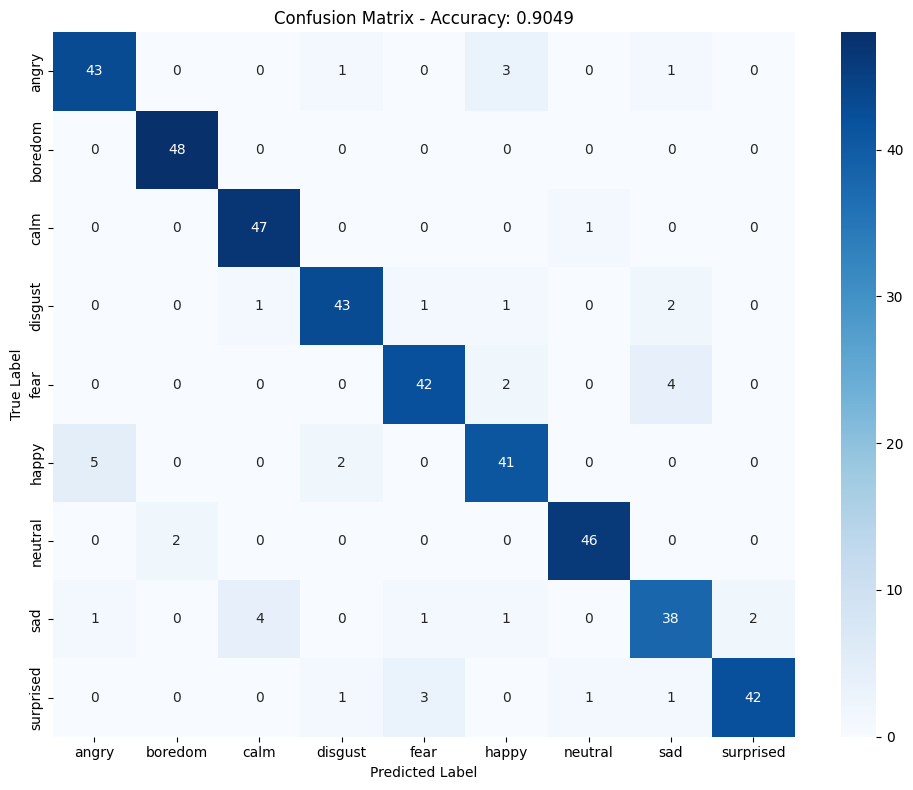

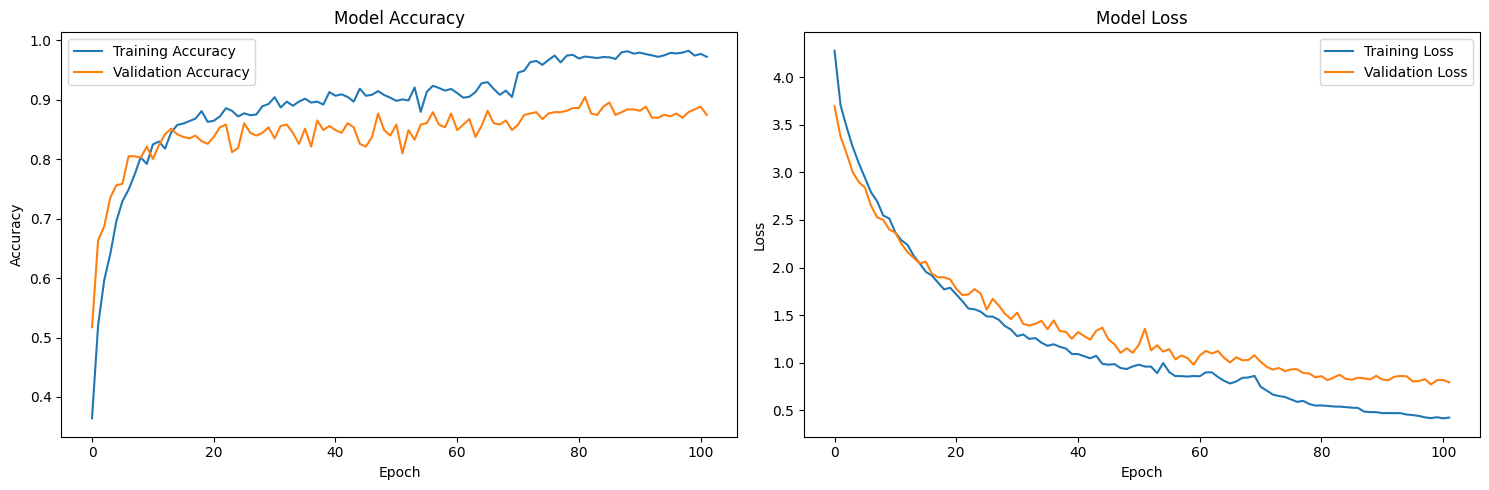


Model saved! Final accuracy: 0.9049
SUCCESS! Achieved accuracy ≥ 90%


In [168]:
# Final evaluation
print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

test_pred = final_model.predict(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
final_accuracy = accuracy_score(y_test, test_pred_classes)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, test_pred_classes, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - Accuracy: {final_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nModel saved! Final accuracy: {final_accuracy:.4f}")
if final_accuracy >= 0.9:
    print("SUCCESS! Achieved accuracy ≥ 90%")
else:
    print(f"Current accuracy: {final_accuracy:.1%}. Try running again or adjusting hyperparameters.")